In [1]:
import pandas as pd

In [2]:
accidents = pd.read_csv('../data/Traffic_Accidents_2019.csv')

In [3]:
accidents.head()

,Accident Number,Date and Time,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Reporting Officer,Collision Type Code,Collision Type Description,...,Harmful Code Description,Street Address,City,State,ZIP,RPA,Precinct,Latitude,Longitude,Mapped Location
0,20190038972,01/15/2019 07:40:00 PM,2,0,0,NaN,N,256374.0,4.0,ANGLE,...,MOTOR VEHICLE IN TRANSPORT,BELL RD & CEDAR POINTE PKWY,ANTIOCH,TN,37013.0,8753.0,SOUTH,36.0449,-86.6671,POINT (-86.6671 36.0449)
1,20190045402,01/17/2019 11:09:00 PM,2,0,0,NaN,Y,405424.0,11.0,Front to Rear,...,PARKED MOTOR VEHICLE,3248 PERCY PRIEST DR,NASHVILLE,TN,37214.0,8955.0,HERMIT,36.1531,-86.6291,POINT (-86.6291 36.1531)
2,20190051468,01/20/2019 12:57:00 PM,2,0,0,NaN,N,834798.0,6.0,SIDESWIPE - OPPOSITE DIRECTION,...,PARKED MOTOR VEHICLE,700 THOMPSON LN,NASHVILLE,TN,37204.0,8305.0,MIDTOW,36.1122,-86.7625,POINT (-86.7625 36.1122)
3,20190088097,02/02/2019 12:38:00 AM,2,0,0,NaN,Y,660929.0,4.0,ANGLE,...,MOTOR VEHICLE IN TRANSPORT;PARKED MOTOR VEHICLE,400 RADNO,NASHVILLE,TN,NaN,NaN,NaN,36.0483,-86.4369,POINT (-86.4369 36.0483)
4,20190091289,02/03/2019 01:25:00 PM,2,0,0,NaN,N,212369.0,4.0,ANGLE,...,MOTOR VEHICLE IN TRANSPORT,ELLINGTON AG CENTER PVTDR & EDMONDSON PK,NASHVILLE,TN,37220.0,8615.0,MIDTOW,36.0618,-86.7405,POINT (-86.7405 36.0618)


First, let's convert the Date and Time column to the datetime type. To save time, we can specify the format.

In [5]:
accidents['Date and Time'] = pd.to_datetime(accidents['Date and Time'], format = '%m/%d/%Y %I:%M:%S %p')

Once we have it in datetime format it becomes easy to answer questions like "How many accidents were there per month?".

In [7]:
(accidents
 .assign(month = accidents['Date and Time'].dt.month_name())
 .month
 .value_counts(sort = False)
)

month
January      2617
February     2766
March        2909
April        3129
May          3058
June         2881
July         2690
August       2933
September    2742
October      3294
November     3051
December     2622
Name: count, dtype: int64

Let's look at how the number of accidents vary by hour of the day.

One method we could try is to extract out the date and hour portions and do a `groupby` + `count`.

In [9]:
(accidents
 .assign(date = accidents['Date and Time'].dt.date, 
         hour = accidents['Date and Time'].dt.hour)     # Create a date and hour column so that we can group
 .groupby(['date', 'hour'])
 ['Accident Number']
 .count()
 .reset_index()
 .head(10)
)

,date,hour,Accident Number
0,2019-01-01,0,6
1,2019-01-01,1,4
2,2019-01-01,2,1
3,2019-01-01,3,4
4,2019-01-01,4,2
5,2019-01-01,5,3
6,2019-01-01,9,1
7,2019-01-01,12,2
8,2019-01-01,13,1
9,2019-01-01,14,4


There is a big problem with this, which can be seen if you look carefully at the output above. There are no rows for 6:00, 7:00, or 8:00 on January 1. This is because there were no accidents during these hours, so there were no rows to count.

A better method (and one that will require less work to pull off) is to use a `Grouper` to group by hour.

In [11]:
(accidents
 .groupby(pd.Grouper(key = 'Date and Time',     # point it to your datetime column
                     freq = '1h',               # How much do you want to group together values?
                     origin = 'epoch'           # This will start times at midnight of 1970-01-01. This ensure
                                                # This ensures that we are starting our first grouped period on the hour
                    ))
 ['Accident Number']
 .count()
 .reset_index()
 .head(10)
)

,Date and Time,Accident Number
0,2019-01-01 00:00:00,6
1,2019-01-01 01:00:00,4
2,2019-01-01 02:00:00,1
3,2019-01-01 03:00:00,4
4,2019-01-01 04:00:00,2
5,2019-01-01 05:00:00,3
6,2019-01-01 06:00:00,0
7,2019-01-01 07:00:00,0
8,2019-01-01 08:00:00,0
9,2019-01-01 09:00:00,1


Late night on November 11, 2019 [Nashville received a rare November snow](https://fox17.com/news/local/nws-nashville-sees-rare-early-november-snow). Let's investigate to see if we can detect any effect on the number of accidents the following morning.

In [13]:
# First, filter down to the following day
snow_day = accidents[(accidents['Date and Time'] >= '2019-11-12') & 
                     (accidents['Date and Time'] < '2019-11-13')]

Now, let's apply a grouper to the our snow day.

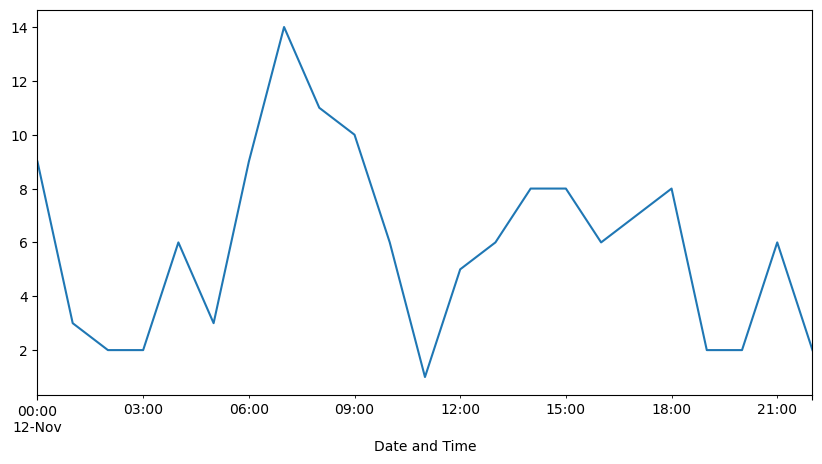

In [15]:
(snow_day
 .groupby(pd.Grouper(key = 'Date and Time',
                     freq = '1h',
                     origin = 'epoch'
                    ))
 ['Accident Number']
 .count()
 .plot(figsize = (10,5))
);

It does look like there were quite a few accidents in the morning, but in isolation, it is hard to know if what we are seeing is unusual. Let's do a comparison with the rest of the data.

In [61]:
accidents_grouped = (accidents
                     .assign(weekday = accidents['Date and Time'].dt.day_name())
                     .query('weekday != "Saturday" and weekday != "Sunday"')   # remove the weekends
                     .groupby(pd.Grouper(key = 'Date and Time',
                                         freq = '1h',
                                         origin = 'epoch'
                                        ))
 ['Accident Number']
 .count()
 .reset_index()       # convert the Date and Time column back to a regular column
)

In [63]:
(accidents_grouped
 .assign(hour = accidents_grouped['Date and Time'].dt.hour)
 .groupby('hour')
 ['Accident Number']
 .agg(['mean', 'std', 'median','max'])
)

,mean,std,median,max
hour,,,,
0,3.961644,3.257056,4.0,15
1,0.504110,0.803912,0.0,4
2,0.449315,0.781504,0.0,4
3,0.479452,0.786381,0.0,4
4,0.430137,0.857207,0.0,6
5,1.161644,1.516813,1.0,10
6,3.000000,2.859340,3.0,14
7,5.290411,4.674344,5.0,22
8,4.819178,4.079588,5.0,15


From this, we can see that in the morning, the 7:00 hour is usually the worst, with an average of more than 5 accidents.

Looking back at the snow day, we can see that while the morning hours did have a high number of crashes, none of them were the worst that occurred in 2019.

However, together the hours or 6, 7, 8, and 9 all had above-average number of crashes. Maybe we can compare this block of time to this block of time across the whole dataset.

One way to accomplish this is to change our grouping frequency to 4 hours. Note that we also need to adjust the origin value so that 6:00 - 10:00 get grouped together.

In [20]:
snow_day.groupby(pd.Grouper(key = 'Date and Time',     
                                     freq = '4h',               
                                     origin = '2018-12-31 02:00:00'  # This will result in the 6:00 AM - 10:00 AM times to be grouped together           
                           ))['Date and Time'].count()

Date and Time
2019-11-11 22:00:00    12
2019-11-12 02:00:00    13
2019-11-12 06:00:00    44
2019-11-12 10:00:00    18
2019-11-12 14:00:00    29
2019-11-12 18:00:00    18
2019-11-12 22:00:00     2
Freq: 4h, Name: Date and Time, dtype: int64

Let's also regroup the full dataset.

In [22]:
accidents_grouped = (accidents
                     .assign(weekday = accidents['Date and Time'].dt.day_name())
                     .query('weekday != "Saturday" and weekday != "Sunday"')
                     .groupby(pd.Grouper(key = 'Date and Time',     
                                     freq = '4h',               
                                     origin = '2018-12-31 02:00:00'                                      
                                    ))
 ['Accident Number']
 .count()
 .reset_index()
)

In [23]:
(accidents_grouped
 .assign(hour = accidents_grouped['Date and Time'].dt.hour)
 .groupby('hour')
 ['Accident Number']
 .agg(['mean', 'std', 'median', 'max'])
)

,mean,std,median,max
hour,,,,
2,2.520548,2.756160,2.0,17
6,16.446575,12.676686,19.0,50
10,14.556164,10.534102,17.0,45
14,21.791781,15.304256,26.0,59
18,10.942466,8.381985,12.0,41
22,7.224044,4.397268,8.0,21


Comparing the snow day to the overall average for the 4 hour period starting at 6:00 AM, we can see that there were an above-average number of accidents. It wasn't the worst day in the whole year, but let's investigate and see where it lands.

This day was the worst Tuesday in 2019, and is tied for the 4th worst day in the whole year.

# End of Instruction

### You want to compare accidents by hour based on Season.  First, divide the dataframe based on season using this rule: March-May = Spring, June-August = Summer, September - November = Fall, December - February = Winter.

In [28]:
accidents['month'] = accidents['Date and Time'].dt.month_name()
accidents

,Accident Number,Date and Time,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Reporting Officer,Collision Type Code,Collision Type Description,...,Street Address,City,State,ZIP,RPA,Precinct,Latitude,Longitude,Mapped Location,month
0,20190038972,2019-01-15 19:40:00,2,0,0,NaN,N,256374.0,4.0,ANGLE,...,BELL RD & CEDAR POINTE PKWY,ANTIOCH,TN,37013.0,8753.0,SOUTH,36.0449,-86.6671,POINT (-86.6671 36.0449),January
1,20190045402,2019-01-17 23:09:00,2,0,0,NaN,Y,405424.0,11.0,Front to Rear,...,3248 PERCY PRIEST DR,NASHVILLE,TN,37214.0,8955.0,HERMIT,36.1531,-86.6291,POINT (-86.6291 36.1531),January
2,20190051468,2019-01-20 12:57:00,2,0,0,NaN,N,834798.0,6.0,SIDESWIPE - OPPOSITE DIRECTION,...,700 THOMPSON LN,NASHVILLE,TN,37204.0,8305.0,MIDTOW,36.1122,-86.7625,POINT (-86.7625 36.1122),January
3,20190088097,2019-02-02 00:38:00,2,0,0,NaN,Y,660929.0,4.0,ANGLE,...,400 RADNO,NASHVILLE,TN,NaN,NaN,NaN,36.0483,-86.4369,POINT (-86.4369 36.0483),February
4,20190091289,2019-02-03 13:25:00,2,0,0,NaN,N,212369.0,4.0,ANGLE,...,ELLINGTON AG CENTER PVTDR & EDMONDSON PK,NASHVILLE,TN,37220.0,8615.0,MIDTOW,36.0618,-86.7405,POINT (-86.7405 36.0618),February
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34687,20190609313,2019-08-15 16:15:00,2,0,0,NaN,N,320581.0,4.0,ANGLE,...,9TH AVN & JEFFERSON ST,NASHVILLE,TN,37208.0,4239.0,NORTH,36.1730,-86.7924,POINT (-86.7924 36.173),August
34688,20190773747,2019-10-23 00:05:00,1,0,0,NaN,N,212312.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,WEST END AV & I440 E ENT RAMP,NASHVILLE,TN,37205.0,6007.0,WEST,36.1364,-86.8220,POINT (-86.822 36.1364),October
34689,20190772331,2019-10-22 09:45:00,2,0,0,NaN,N,225777.0,5.0,SIDESWIPE - SAME DIRECTION,...,CENTENNIAL BLVD & CENTENNIAL BOULEVARD R,NASHVILLE,TN,37209.0,4641.0,WEST,36.1712,-86.8727,POINT (-86.8727 36.1712),October
34690,20190659186,2019-09-04 07:55:00,2,0,0,NaN,Y,876581.0,11.0,Front to Rear,...,RIVERCHASE BLVD & GALLATIN PKEN,MADISON,TN,37115.0,1721.0,MADISO,36.3086,-86.6815,POINT (-86.6815 36.3086),September


In [29]:
for index, row in accidents.iterrows():
    if row.month == "March" :
        accidents.loc[index ,'season'] = 'Spring'
        
    elif row.month == "April":
        accidents.loc[index ,'season'] = 'Spring'
        
    elif row.month ==  "May":
        accidents.loc[index ,'season'] = 'Spring'
        
    elif row.month == "June":
        accidents.loc[index ,'season'] = 'Summer'
        
    elif row.month == "July":
        accidents.loc[index ,'season'] = 'Summer'
        
    elif row.month == "August":
        accidents.loc[index ,'season'] = 'Summer'
        
    elif row.month == "September":
        accidents.loc[index ,'season'] = 'Fall'

    elif row.month == "October":
        accidents.loc[index ,'season'] = 'Fall'
        
    elif row.month == "November":
        accidents.loc[index ,'season'] = 'Fall'
        
    else:
       accidents.loc[index, "season"] = 'Winter'


In [33]:
accidents


,Accident Number,Date and Time,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Reporting Officer,Collision Type Code,Collision Type Description,...,City,State,ZIP,RPA,Precinct,Latitude,Longitude,Mapped Location,month,season
0,20190038972,2019-01-15 19:40:00,2,0,0,NaN,N,256374.0,4.0,ANGLE,...,ANTIOCH,TN,37013.0,8753.0,SOUTH,36.0449,-86.6671,POINT (-86.6671 36.0449),January,Winter
1,20190045402,2019-01-17 23:09:00,2,0,0,NaN,Y,405424.0,11.0,Front to Rear,...,NASHVILLE,TN,37214.0,8955.0,HERMIT,36.1531,-86.6291,POINT (-86.6291 36.1531),January,Winter
2,20190051468,2019-01-20 12:57:00,2,0,0,NaN,N,834798.0,6.0,SIDESWIPE - OPPOSITE DIRECTION,...,NASHVILLE,TN,37204.0,8305.0,MIDTOW,36.1122,-86.7625,POINT (-86.7625 36.1122),January,Winter
3,20190088097,2019-02-02 00:38:00,2,0,0,NaN,Y,660929.0,4.0,ANGLE,...,NASHVILLE,TN,NaN,NaN,NaN,36.0483,-86.4369,POINT (-86.4369 36.0483),February,Winter
4,20190091289,2019-02-03 13:25:00,2,0,0,NaN,N,212369.0,4.0,ANGLE,...,NASHVILLE,TN,37220.0,8615.0,MIDTOW,36.0618,-86.7405,POINT (-86.7405 36.0618),February,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34687,20190609313,2019-08-15 16:15:00,2,0,0,NaN,N,320581.0,4.0,ANGLE,...,NASHVILLE,TN,37208.0,4239.0,NORTH,36.1730,-86.7924,POINT (-86.7924 36.173),August,Summer
34688,20190773747,2019-10-23 00:05:00,1,0,0,NaN,N,212312.0,0.0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,...,NASHVILLE,TN,37205.0,6007.0,WEST,36.1364,-86.8220,POINT (-86.822 36.1364),October,Fall
34689,20190772331,2019-10-22 09:45:00,2,0,0,NaN,N,225777.0,5.0,SIDESWIPE - SAME DIRECTION,...,NASHVILLE,TN,37209.0,4641.0,WEST,36.1712,-86.8727,POINT (-86.8727 36.1712),October,Fall
34690,20190659186,2019-09-04 07:55:00,2,0,0,NaN,Y,876581.0,11.0,Front to Rear,...,MADISON,TN,37115.0,1721.0,MADISO,36.3086,-86.6815,POINT (-86.6815 36.3086),September,Fall


### Next, find the average number of accident per day for each hour by season.

In [73]:
(accidents
 .assign(hour = accidents['Date and Time'].dt.hour)
 .groupby('season')
 ['Accident Number']
 .agg(['mean']))

,mean
season,
Fall,2.019076e+10
Spring,2.019029e+10
Summer,2.019052e+10
Winter,2.019034e+10


### Finally, create a facetgrid that compares the mean accidents over a 24-hour span by season.  Is there anything interesting?  Any follow up questions you can think of?